#### Natural Language Processing (NLP) with BERT

- __Install packages__

- __Import Libraries__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import string
import re

import tensorflow_hub as hub
from tensorflow.keras import layers
import bert

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [2]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping: no known devices.


In [3]:
def plotLoss(history):

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

- __Word Normalizer__

In [4]:
def normalizer(tweet):
    no_urls = re.sub(r"http\S+", " " ,tweet)
    only_letters = re.sub("[^a-zA-Z]", " ",no_urls)
    return only_letters

In [5]:
%run -i 'bert_encode.py'
# def bert_encode(texts, tokenizer, max_len=128):
#     all_tokens = []
#     all_masks = []
#     all_segments = []
    
#     for text in texts:
#         text = tokenizer.tokenize(text)
            
#         text = text[:max_len-2]
#         input_sequence = ["[CLS]"] + text + ["[SEP]"]
#         pad_len = max_len - len(input_sequence)
        
#         tokens = tokenizer.convert_tokens_to_ids(input_sequence)
#         tokens += [0] * pad_len
#         pad_masks = [1] * len(input_sequence) + [0] * pad_len
#         segment_ids = [0] * max_len
        
#         all_tokens.append(tokens)
#         all_masks.append(pad_masks)
#         all_segments.append(segment_ids)
    
#     return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

#### Import the data file

In [6]:
data = pd.read_csv("./input/goodbad.csv")

data['tweets'] =data['tweets'].apply(normalizer)

In [7]:
train=data.sample(frac=0.85,random_state=31415) #random state is a seed value
test=data.drop(train.index)

In [8]:
#Loding pretrained bert layer
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)

In [9]:
# Loading tokenizer from the bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocab_file, do_lower_case)

In [10]:
MAX_LEN = 128

# encode train set 
train_input = bert_encode(train['tweets'], tokenizer, max_len=MAX_LEN)
# encode  test set 
test_input = bert_encode(test['tweets'], tokenizer, max_len= MAX_LEN )
train_labels = train['label']

In [11]:
#create keras input
input_word_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")
input_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_mask")
segment_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="segment_ids")

#add keras layers
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])  
layer1 = sequence_output[:, 0, :]
layer2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)(layer1)#add layers here
out = Dense(1, activation='sigmoid')(layer2)   

# intilize model
model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
model.compile(Adam(lr=5e-4), loss='binary_crossentropy', metrics=['accuracy' ,'mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [12]:
# train
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.18,
    epochs=4,
    batch_size=32
)

Epoch 1/4
187/187 [==============================] - 1854s 10s/step - loss: 0.4491 - accuracy: 0.7919 - mse: 0.1453 - val_loss: 0.3128 - val_accuracy: 0.8750 - val_mse: 0.0946
Epoch 2/4
187/187 [==============================] - 1758s 9s/step - loss: 0.3214 - accuracy: 0.8689 - mse: 0.0971 - val_loss: 0.2949 - val_accuracy: 0.8750 - val_mse: 0.0896
Epoch 3/4
187/187 [==============================] - 1829s 10s/step - loss: 0.2875 - accuracy: 0.8856 - mse: 0.0871 - val_loss: 0.3001 - val_accuracy: 0.8697 - val_mse: 0.0928
Epoch 4/4
187/187 [==============================] - 1798s 10s/step - loss: 0.2730 - accuracy: 0.8902 - mse: 0.0824 - val_loss: 0.2873 - val_accuracy: 0.8811 - val_mse: 0.0871


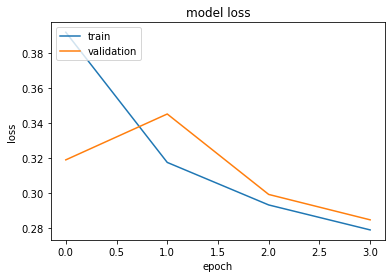

41/41 [==============================] - 24s 595ms/step - loss: 0.3185 - accuracy: 0.8694 - mse: 0.0986


[0.31846529245376587, 0.8693623542785645, 0.09858082979917526]

In [13]:
plotLoss(train_history)
model.evaluate(test_input,test["label"])

In [14]:
model.save('goodbad')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: goodbad\assets


INFO:tensorflow:Assets written to: goodbad\assets


In [16]:
data2 = pd.read_csv("./input/urgentrelaxed.csv")

data2['tweets'] =data2['tweets'].apply(normalizer)

In [17]:
train2=data2.sample(frac=0.85,random_state=31415) #random state is a seed value
test2=data2.drop(train2.index)

In [18]:
MAX_LEN = 128

# encode train set 
train_input2 = bert_encode(train2['tweets'], tokenizer, max_len=MAX_LEN)
# encode  test set 
test_input2 = bert_encode(test2['tweets'], tokenizer, max_len= MAX_LEN )
train_labels2 = train2['label']

In [19]:
#create keras input
input_word_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")
input_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_mask")
segment_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="segment_ids")

#add keras layers
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])  
layer1 = sequence_output[:, 0, :]
layer2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)(layer1)#add layers here
out = Dense(1, activation='sigmoid')(layer2)   

# intilize model
model2 = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
model2.compile(Adam(lr=5e-4), loss='binary_crossentropy', metrics=['accuracy' ,'mse'])
model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [20]:
# train
train_history2 = model2.fit(
    train_input2, train_labels2,
    validation_split=0.18,
    epochs=4,
    batch_size=32
)

Epoch 1/4
127/127 [==============================] - 97s 762ms/step - loss: 0.4271 - accuracy: 0.7990 - mse: 0.1379 - val_loss: 0.3577 - val_accuracy: 0.8225 - val_mse: 0.1147
Epoch 2/4
127/127 [==============================] - 96s 752ms/step - loss: 0.3164 - accuracy: 0.8621 - mse: 0.0984 - val_loss: 0.3033 - val_accuracy: 0.8607 - val_mse: 0.0950
Epoch 3/4
127/127 [==============================] - 96s 752ms/step - loss: 0.2815 - accuracy: 0.8809 - mse: 0.0868 - val_loss: 0.3235 - val_accuracy: 0.8494 - val_mse: 0.1033
Epoch 4/4
127/127 [==============================] - 96s 752ms/step - loss: 0.2631 - accuracy: 0.8875 - mse: 0.0805 - val_loss: 0.2829 - val_accuracy: 0.8629 - val_mse: 0.0900


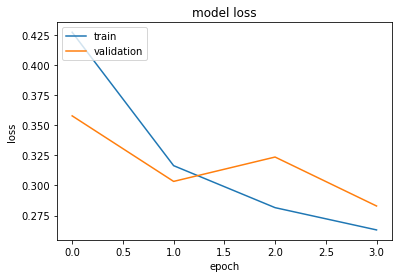

28/28 [==============================] - 16s 584ms/step - loss: 0.3449 - accuracy: 0.8499 - mse: 0.1066


[0.34487268328666687, 0.8499427437782288, 0.10659082978963852]

In [21]:
plotLoss(train_history2)
model2.evaluate(test_input2,test2["label"])

In [22]:
model2.save('urgency')

INFO:tensorflow:Assets written to: urgency\assets


INFO:tensorflow:Assets written to: urgency\assets


In [24]:
#!pip install bert-for-tf2
#!pip install sentencepiece

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert

import string
import re

def normalizer(tweet):
    no_urls = re.sub(r"http\S+", " " ,tweet)
    only_letters = re.sub("[^a-zA-Z]", " ",no_urls)
    return only_letters

def bert_encode(texts, tokenizer, max_len=128):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def predictOnText(text, model1, model2):

  text = normalizer(text)

  texts = [text]
  pred_input = bert_encode(texts, tokenizer, max_len= MAX_LEN )

  return model1.predict(pred_input), model2.predict(pred_input)

  

#Loding pretrained bert layer
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)

# Loading tokenizer from the bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocab_file, do_lower_case)

MAX_LEN = 128

goodbad = keras.models.load_model('./goodbad')
urgency = keras.models.load_model('./urgency')

sample = "This a great sample text, that you must text now!"
predictOnText(sample , goodbad, urgency)

(array([[0.2782949]], dtype=float32), array([[0.9343576]], dtype=float32))

In [25]:
sample = 'Would you like to eat some ice cream'
predictOnText(sample , goodbad, urgency)

(array([[0.9104377]], dtype=float32), array([[0.06078823]], dtype=float32))